In [41]:
import pandas as pd
import numpy as np
import json
import os
from multiprocessing import Pool
from tqdm.notebook import tqdm
import gc
import pickle
import joblib
import cv2
#import bz2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import config


In [104]:
class Config(object):
    DATA_PATH = 'data/imaterialist-fashion-2020-fgvc7'
    IMAGE_SIZE = 256
    NO_OF_CLASSES = 46
    BATCH_SIZE = 8
    OUTPUT_MASK_SIZE=256
    RESIZE=True
    
        

In [224]:
class Dataset():
    def __init__ (self, config, df, random_seed=0):
        self.CONFIG = config
        self.TRAINING_DATA_PATH = self.CONFIG.DATA_PATH + '/train/'
        self.TRAINING_DATA_FRAME = df
        self.DATASET_IDXS = self.TRAINING_DATA_FRAME.ImageId.unique()
        self.DATASET_SIZE = self.DATASET_IDXS.shape[0]
        
        np.random.seed(random_seed)
        np.random.shuffle(self.DATASET_IDXS)
        self.CURRENT_IDX=0
        
    def get_image(self, image_id, resize=True):
        img = cv2.cvtColor( cv2.imread(self.TRAINING_DATA_PATH+image_id+'.jpg'), cv2.COLOR_BGR2RGB)
        if resize:
            return cv2.resize(img, 
                              (self.CONFIG.IMAGE_SIZE, self.CONFIG.IMAGE_SIZE), 
                              interpolation = cv2.INTER_NEAREST)
        else:
            return img
        
    def make_single_mask(self, encoded_string, height, width):
        splitted_string = np.array(list(map(int, encoded_string.split()))).reshape(-1,2)
        mask = np.zeros((height*width), dtype=np.uint8)
        for start_indice, run_length in splitted_string:
            start_indice-=1
            mask[start_indice:start_indice+run_length] = 1
        return mask.reshape((height, width), order='F')
    
    def get_box(self, mask):
        w = np.sum(mask, axis=0)
        h = np.sum(mask, axis=1)
        x1, x2 = 0, len(w)-1
        y1, y2 = 0, len(h)-1
        while w[x1]==0:
            x1+=1
        while w[x2]==0:
            x2-=1
        while h[y1]==0:
            y1+=1
        while h[y2]==0:
            y2-=1

        return np.array([x1, y1, x2-x1, y2-y1])
    
    def get_mask_and_box(self, image_id, resize=True):
        query = self.TRAINING_DATA_FRAME[self.TRAINING_DATA_FRAME.ImageId==image_id]
        encoded_pixels = query.EncodedPixels
        class_ids = query.ClassId
        height, width = list(query.Height)[0], list(query.Width)[0]
        
        if resize:
            mask = np.zeros((self.CONFIG.OUTPUT_MASK_SIZE, self.CONFIG.OUTPUT_MASK_SIZE, self.CONFIG.NO_OF_CLASSES), 
                            dtype=np.uint8)
        else:
            mask = np.zeros((height, width, self.CONFIG.NO_OF_CLASSES), 
                            dtype=np.uint8)
        boxes = np.zeros((self.CONFIG.NO_OF_CLASSES, 4))
            
        for _, (encoded_pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            sub_mask = self.make_single_mask(encoded_pixel_str, height, width)
            if resize:
                sub_mask = cv2.resize(sub_mask, 
                                      (self.CONFIG.OUTPUT_MASK_SIZE, self.CONFIG.OUTPUT_MASK_SIZE), 
                                      interpolation=cv2.INTER_NEAREST)
            mask[:,:,class_id] = sub_mask
            boxes[class_id,:] = self.get_box(sub_mask)
        return mask, boxes
    
    
    
    def sample_next_batch(self):
        next_idx = self.CURRENT_IDX+self.CONFIG.BATCH_SIZE
        if next_idx>self.DATASET_SIZE-1:
            next_idx = self.CONFIG.BATCH_SIZE-(self.DATASET_SIZE-self.CURRENT_IDX)
            batch_idxs = np.concatenate((self.DATASET_IDXS[self.CURRENT_IDX:], 
                                        self.DATASET_IDXS[:next_idx]))
            self.CURRENT_IDX = next_idx
            return batch_idxs, True
        else:
            batch_idxs = self.DATASET_IDXS[self.CURRENT_IDX:next_idx]
            self.CURRENT_IDX = next_idx
            return batch_idxs, False
    
    def get_next_batch(self, resize=True):
        batch_idxs, epoch_finish = self.sample_next_batch()
        print(batch_idxs)
        train_images, test_images, bounding_boxes = [], [], []
        for image_id in batch_idxs:
            train_images.append(self.get_image(image_id, resize=resize))
            mask, boxes = self.get_mask_and_box(image_id, resize=resize)
            test_images.append(mask)
            bounding_boxes.append(boxes)
        return np.array(train_images), np.array(test_images), np.array(bounding_boxes), epoch_finish
            
        
         

# Model

In [ ]:
d.get_next_batch
    

In [153]:
import torchvision

In [156]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [158]:
from PIL import Image

In [182]:
len(COCO_INSTANCE_CATEGORY_NAMES)

91

In [159]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class


In [173]:
from torchvision import transforms as T
a,b,c = get_prediction(config.DATA_PATH+'/train/'+train_df[train_df.columns[0]][0]+'.jpg', .5)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [179]:
c

['person', 'tie', 'tie']

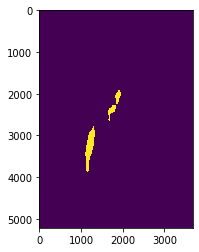

In [181]:
plt.imshow(a[2])

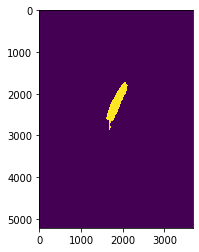

In [180]:
plt.imshow(a[1])

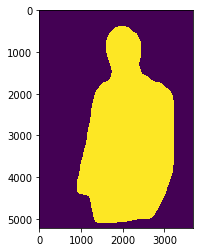

In [178]:
plt.imshow(a[0])

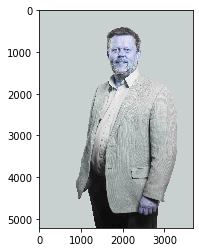

In [176]:
plt.imshow(cv2.imread(config.DATA_PATH+'/train/'+train_df[train_df.columns[0]][0]+'.jpg'))

# Main

In [177]:
config = Config()
train_df = pd.read_csv(config.DATA_PATH+'/train.csv')

In [225]:
d = Dataset(config, train_df)

In [226]:
a, b, c, d = d.get_next_batch(resize=False)

['bcbc4cea8c50041454a5f7aabf77ad46' 'e0077248f5fa179c0cd638a7ddccbed4'
 '236ccdef3ad1ebc090c38ccac0fee439' 'f128bf2de1df3515ea468958fe79c2b1'
 '55f53fd1b05d44a1c5911df5a4265bfc' '8b3ef60d7abeb2067355398100653442'
 'd347fccadc4b7517f983fd965f3cd660' '935ac3caf91a29693b7cc03501b0ab98']


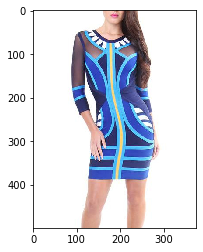

In [229]:
plt.imshow(a[0])

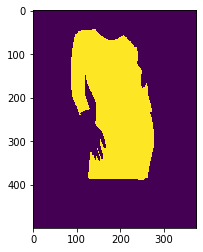

In [236]:
plt.imshow(b[0][:,:,10])

In [237]:
c.shape

(8, 46, 4)

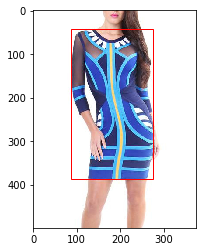

In [238]:
from matplotlib.patches import Rectangle
plt.imshow(a[0])
plt.gca().add_patch(Rectangle((c[0][10][0], c[0][10][1]),c[0][10][2],c[0][10][3],linewidth=1,edgecolor='r',facecolor='none'))

In [230]:
train_df[train_df.ImageId == 'bcbc4cea8c50041454a5f7aabf77ad46']

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
245469,bcbc4cea8c50041454a5f7aabf77ad46,66546 1 67046 2 67545 4 68045 5 68545 6 69045 ...,500,375,33,190
245470,bcbc4cea8c50041454a5f7aabf77ad46,43619 34 44108 77 44597 97 45088 112 45581 122...,500,375,31,"159,204"
245471,bcbc4cea8c50041454a5f7aabf77ad46,116666 8 117157 23 117648 39 118139 51 118630 ...,500,375,31,159
245472,bcbc4cea8c50041454a5f7aabf77ad46,43619 34 44108 77 44597 97 45088 112 45581 122...,500,375,10,"106,115,127,142,150,295,301,318"


In [216]:
i = d.get_image('00000663ed1ff0c4e0132b9b9ac53f6e', resize=False)

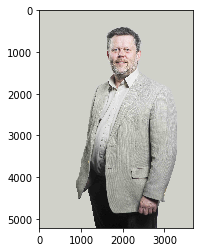

In [198]:
plt.imshow(i)

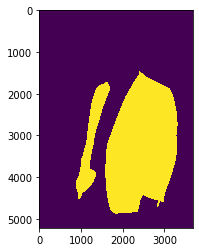

In [202]:
plt.imshow(m[:,:,4])

In [203]:
m[:,:,4].shape

(5214, 3676)

In [207]:
w = np.sum(m[:,:,4], axis=0)

In [209]:
i=0
j = len(w)-1
while w[i]==0:
    i+=1
while w[j]==0:
    j-=1

In [210]:
i,j

(875, 3309)

In [212]:
def get_box(mask):
    w = np.sum(mask, axis=0)
    h = np.sum(mask, axis=1)
    x1, x2 = 0, len(w)-1
    y1, y2 = 0, len(h)-1
    while w[x1]==0:
        x1+=1
    while w[x2]==0:
        x2-=1
    while h[y1]==0:
        y1+=1
    while h[y2]==0:
        y2-=1
    
    return x1, y1, x2-x1, y2-y1

In [213]:
get_box(m[:,:,4])

(875, 1437, 2434, 3434)

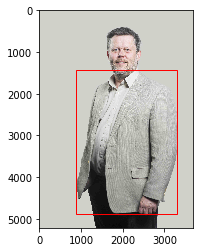

In [218]:
from matplotlib.patches import Rectangle
plt.imshow(i)
plt.gca().add_patch(Rectangle((875, 1437),2434,3434,linewidth=1,edgecolor='r',facecolor='none'))


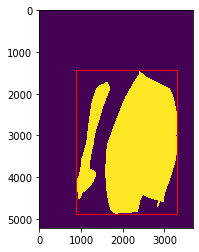

In [219]:
from matplotlib.patches import Rectangle
plt.imshow(m[:,:,4])
plt.gca().add_patch(Rectangle((875, 1437),2434,3434,linewidth=1,edgecolor='r',facecolor='none'))